# Select patient with valid data for selected signal sources
- sao2, 
- heartrate, 
- respiration, 
- systemicsystolic, 
- systemicdiastolic, 
- systemicmean
- netto input-output volume (io_nettotal)
- urine volume

In [1]:
import sys
sys.path.append("../../")

import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import icd10
from icd9cms.icd9 import search

from collections import Counter

from projects.data_cleaning import *

os.makedirs("_cache", exist_ok=True)

DATABASE_DIR = '../../outputs/all/'


In [2]:
vitals_selected = ['sao2', 'heartrate', 'respiration', 'systemicsystolic', 'systemicdiastolic', 'systemicmean']
entry_name = 'Urine'
entry = 'celllabel'
entry_group = 'intakeOutput'

# arf: acute renal failure
pid_arf = []
pid_arf_valid = []

pid_arf_cache_path = '_cache/pid_arf.npy'
pid_arf_valid_cache_path = '_cache/pid_arf_valid.npy'
if os.path.exists(pid_arf_cache_path) and os.path.exists(pid_arf_valid_cache_path):
    pid_arf = np.load(pid_arf_cache_path, allow_pickle=True)
    pid_arf_valid = np.load(pid_arf_valid_cache_path, allow_pickle=True)

else:
    for filename in os.listdir(DATABASE_DIR):
        data = json.load(open(DATABASE_DIR+filename))
        if len(data['diagnosis']['diagnosisoffset']) > 0:
            is_arf = False
            for diagnosisstr in data['diagnosis']['diagnosisstring']:
                if 'acute renal failure' in diagnosisstr:
                    pid_arf.append(data['patient']['patientunitstayid'][0])
                    is_arf = True
                    break
            if is_arf:
                io_nettotal = data['intakeOutput']['nettotal']
                subset_idx = select_entry_subset(data, entry_group, entry, entry_name)
                urine = select_list_subset_with_index(data[entry_group]['cellvaluenumeric'], subset_idx)

                if valid_data_length(io_nettotal) == 0:
                    continue
                if len(urine) == 0:
                    continue
                for vital in vitals_selected:
                    if valid_data_length(data['vitalPeriodic'][vital]) == 0:
                        continue
                pid_arf_valid.append(data['patient']['patientunitstayid'][0])
                            
    np.save(pid_arf_cache_path, pid_arf)
    np.save(pid_arf_valid_cache_path, pid_arf_valid)

# Check ICD code for patient with ARF diagnosis

In [3]:
icd_code = {}
for pid in pid_arf_valid:
    data = load_patient_data_by_id(DATABASE_DIR, pid)
    dx = data['diagnosis']['diagnosisstring']
    icds = data['diagnosis']['icd9code']
    for d, icd in zip(dx, icds):
        if 'acute renal failure' in d:
            if icd not in icd_code:
                icd_code[icd] = [d]
            else:
                icd_code[icd].append(d)

icd_code_count = {}
for icd in icd_code:
    count = Counter(icd_code[icd])
    icd_code_count[icd] = {k:v for k,v in sorted(count.items(), key=lambda item: item[1], reverse=True)}

In [4]:
for icd in icd_code_count:
    print(f'\nicd9code in database : {icd}')
    for dx in icd_code_count[icd]:
        print(f'-- {dx}: {icd_code_count[icd][dx]}')


icd9code in database : 584.9, N17.9
-- renal|disorder of kidney|acute renal failure: 13032
-- renal|disorder of kidney|acute renal failure|due to hypovolemia/decreased circulating volume: 932
-- renal|disorder of kidney|acute renal failure|due to sepsis: 578
-- renal|disorder of kidney|acute renal failure|etiology unknown: 278
-- renal|disorder of kidney|acute renal failure|due to rhabdomyolysis: 260
-- renal|disorder of kidney|acute renal failure|due to renal ischemia: 175
-- renal|disorder of kidney|acute renal failure|due to nephrotoxic agents: 58
-- renal|disorder of kidney|acute renal failure|unstable during hemodialysis: 33
-- renal|disorder of kidney|acute renal failure|due to interstitial nephritis from drugs: 29
-- surgery|renal issues|acute renal failure: 14
-- renal|disorder of kidney|acute renal failure|due to cardio-pulmonary bypass: 12
-- renal|disorder of kidney|acute renal failure|due to nephrotoxic agents|hemolysis: 12
-- renal|disorder of kidney|acute renal failure|d

# Save patient with diagnosis code "584.9, N17.9"

In [5]:
pid_arf_5849_cache_path = '_cache/pid_arf_5849.npy'
if os.path.exists(pid_arf_5849_cache_path):
    pid_arf_5849 = np.load(pid_arf_cache_path, allow_pickle=True)

else:
    pid_arf_5849 = {}
    for pid in pid_arf_valid:
        data = load_patient_data_by_id(DATABASE_DIR, pid)
        icds = data['diagnosis']['icd9code'] 
        timestamps = data['diagnosis']['diagnosisoffset']
        priority = data['diagnosis']['diagnosispriority']
        for icd, ts, prior in zip(icds, timestamps, priority):
            if icd == '584.9, N17.9':
                if pid in pid_arf_5849:
                    pid_arf_5849[pid].append([ts, prior])
                else:
                    pid_arf_5849[pid] = [ts, prior]
    np.save(pid_arf_5849_cache_path, pid_arf_5849)

# Analyse patient data 6h before the ARF event

In [6]:
SELECTED_SIGNALS = [
    # vitals
    'heartrate', 'respiration', 'sao2',
    'systemicsystolic', #'systemicdiastolic', 'systemicmean', 
    # intake & output
    'nettotal', 'Urine', #'intaketotal', 'outputtotal', 
    # lab test
    'BUN', 'creatinine', #'urinary sodium', 'urinary osmolality'
    #'bedside glucose', 'potassium', 'sodium', 'Hgb', 'chloride',
]

SIGNAL_WINDOW_SIZE = {
    #UNIT: MIN
    'heartrate': 360, 
    'respiration': 360, 
    'sao2': 360,
    'systemicsystolic': 360,
    'nettotal': 1440, 
    'Urine': 1440,
    'BUN': 1440, 
    'creatinine': 1440,
}

data_mapping = pd.read_csv('../../' + DATA_MAPPING_TSV_FILE, sep='\t', header=0)
uid_dict = data_mapping[['ParamNameOrigin', 'TableUID']]
uid_dict = {uid_dict.iloc[i, 0]: uid_dict.iloc[i, 1] 
            for i in range(uid_dict.shape[0])}

dx_target = '584.9, N17.9'
dx_target_uid = uid_dict[dx_target]
print("UID :", dx_target_uid)

UID : 700003


## Example: plot of one patient

In [7]:
# pid = pid_arf_5849[1300]
# patient_data = pd.read_csv(f'../../{DATA_CLEANING_OUTPUT_FOLDER}/data_{pid}.dsv',
#                            sep='$', header=0)

# dx_list = patient_data[patient_data['UID'] > 7e5]
# dx_target_list = dx_list[dx_list['UID'] == dx_target_uid]

# nrows, ncols = 2, 4
# fig, axs = plt.subplots(nrows, ncols, figsize=(20, 8))
# fig.suptitle(f'Patient {pid}, icd9code {dx_target}')

# for i in range(dx_target_list.shape[0]):
#     dx = dx_target_list.iloc[i]
#     ts = dx['Offset']
    
#     # skipped if diagnosis below 6hrs
#     if ts < 360:
#         continue
    
#     # ts_prev = dx_list[dx_list['Offset'] < ts]
#     # if (ts_prev.shape[0] == 0) or (ts - ts_prev['Offset'].iloc[-1]) >= 600:
#     for si, sig in enumerate(SELECTED_SIGNALS):
#         uid = uid_dict[sig]
#         sig_data = sig_data_before_event(uid, patient_data, ts,
#                                 SIGNAL_WINDOW_SIZE[sig])

#         irow = si // 4
#         icol = si % 4
#         axs[irow][icol].plot((sig_data['Offset']-ts)/60, sig_data['Value'])
#         axs[irow][icol].set_title(sig)


In [95]:
def sig_exist_Xhrs(offset, value, ts, window):    
    return offset[(offset >= 0) & (offset < ts) & (offset >= ts - window)], value[(offset >= 0) & (offset < ts) & (offset >= ts - window)]

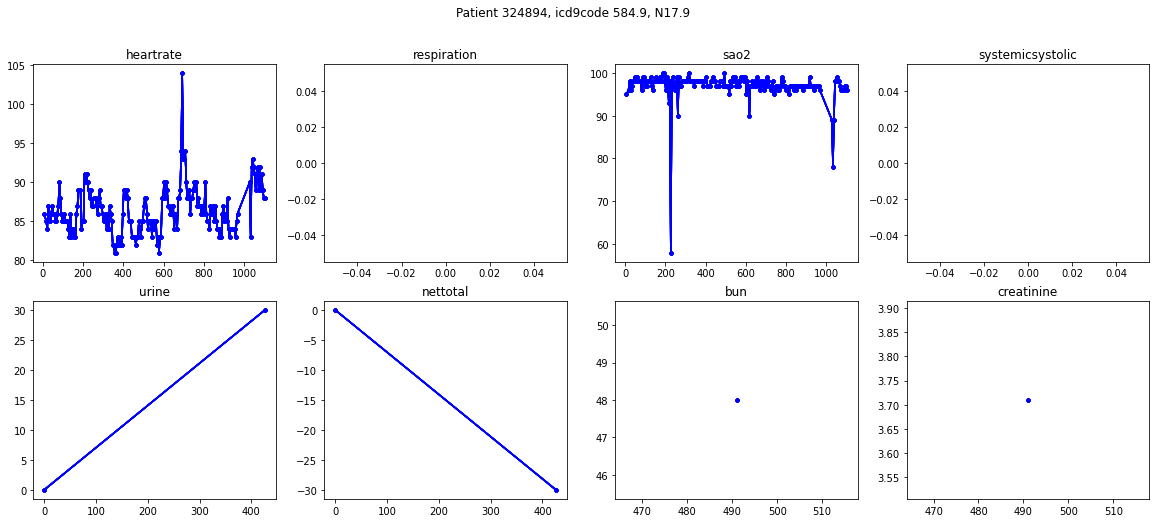

In [102]:
pid = pid_arf_5849[1300]
patient_data = load_patient_data_by_id(DATABASE_DIR, pid)

sorted_ids = np.argsort(patient_data['diagnosis']['diagnosisoffset'])
patient_data['diagnosis']['icd9code'] = np.array(patient_data['diagnosis']['icd9code'])[sorted_ids]
patient_data['diagnosis']['diagnosisoffset'] = np.array(patient_data['diagnosis']['diagnosisoffset'])[sorted_ids]
patient_data['diagnosis']['diagnosispriority'] = np.array(patient_data['diagnosis']['diagnosispriority'])[sorted_ids]

patient_data['diagnosis']['diagnosispriority'][np.where(patient_data['diagnosis']['icd9code']==dx_target)]
patient_data['diagnosis']['diagnosisoffset'][np.where(patient_data['diagnosis']['icd9code']==dx_target)]
patient_data['diagnosis']['icd9code'][np.where(patient_data['diagnosis']['icd9code']==dx_target)]

sorted_ids = np.argsort(patient_data['vitalPeriodic']['observationoffset'])
patient_data['vitalPeriodic']['observationoffset'] = np.array(patient_data['vitalPeriodic']['observationoffset'])[sorted_ids]
patient_data['vitalPeriodic']['heartrate'] = np.array(patient_data['vitalPeriodic']['heartrate'])[sorted_ids]
patient_data['vitalPeriodic']['respiration'] = np.array(patient_data['vitalPeriodic']['respiration'])[sorted_ids]
patient_data['vitalPeriodic']['sao2'] = np.array(patient_data['vitalPeriodic']['sao2'])[sorted_ids]
patient_data['vitalPeriodic']['systemicsystolic'] = np.array(patient_data['vitalPeriodic']['systemicsystolic'])[sorted_ids]

subset_idx = select_entry_subset(patient_data, 'intakeOutput', 'celllabel', 'Urine')
sorted_ids = np.argsort(np.array(patient_data['intakeOutput']['intakeoutputoffset'])[subset_idx])
urine = np.array(select_list_subset_with_index(patient_data['intakeOutput']['cellvaluenumeric'], subset_idx))[sorted_ids]
urine_offset = np.array(patient_data['intakeOutput']['intakeoutputoffset'])[subset_idx][sorted_ids]

sorted_ids = np.argsort(patient_data['intakeOutput']['intakeoutputoffset'])
patient_data['intakeOutput']['intakeoutputoffset'] = np.array(patient_data['intakeOutput']['intakeoutputoffset'])[sorted_ids]
patient_data['intakeOutput']['nettotal'] = np.array(patient_data['intakeOutput']['nettotal'])[sorted_ids]

subset_idx = select_entry_subset(patient_data, 'lab', 'labname', 'BUN')
sorted_ids = np.argsort(np.array(patient_data['lab']['labresultoffset'])[subset_idx])
bun = np.array(select_list_subset_with_index(patient_data['lab']['labresult'], subset_idx))[sorted_ids]
bun_offset = np.array(patient_data['lab']['labresultoffset'])[subset_idx][sorted_ids]

subset_idx = select_entry_subset(patient_data, 'lab', 'labname', 'creatinine')
sorted_ids = np.argsort(np.array(patient_data['lab']['labresultoffset'])[subset_idx])
creatinine = np.array(select_list_subset_with_index(patient_data['lab']['labresult'], subset_idx))[sorted_ids]
creatinine_offset = np.array(patient_data['lab']['labresultoffset'])[subset_idx][sorted_ids]

nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 8))
fig.suptitle(f'Patient {pid}, icd9code {dx_target}')

for i in range(len(icds)):
    dx = icds[i]
    ts = timestamps[i]
    
    # skipped if diagnosis below 6hrs
    if ts < 360:
        continue

    x, y = sig_exist_Xhrs(patient_data['vitalPeriodic']['observationoffset'], 
                          patient_data['vitalPeriodic']['heartrate'], ts, ts)
    axs[0][0].plot(x, y, 'b.-')
    axs[0][0].set_title('heartrate')

    x, y = sig_exist_Xhrs(patient_data['vitalPeriodic']['observationoffset'], 
                          patient_data['vitalPeriodic']['respiration'], ts, ts)
    axs[0][1].plot(x, y, 'b.-')
    axs[0][1].set_title('respiration')

    x, y = sig_exist_Xhrs(patient_data['vitalPeriodic']['observationoffset'], 
                          patient_data['vitalPeriodic']['sao2'], ts, ts)
    axs[0][2].plot(x, y, 'b.-')
    axs[0][2].set_title('sao2')

    x, y = sig_exist_Xhrs(patient_data['vitalPeriodic']['observationoffset'], 
                          patient_data['vitalPeriodic']['systemicsystolic'], ts, ts)
    axs[0][3].plot(x, y, 'b.-')
    axs[0][3].set_title('systemicsystolic')

    x, y = sig_exist_Xhrs(urine_offset, urine, ts, ts)
    axs[1][0].plot(x, y, 'b.-')
    axs[1][0].set_title('urine')

    x, y = sig_exist_Xhrs(patient_data['intakeOutput']['intakeoutputoffset'], 
                          patient_data['intakeOutput']['nettotal'], ts, ts)
    axs[1][1].plot(x, y, 'b.-')
    axs[1][1].set_title('nettotal')

    x, y = sig_exist_Xhrs(bun_offset, bun, ts, ts)
    axs[1][2].plot(x, y, 'b.-')
    axs[1][2].set_title('bun')

    x, y = sig_exist_Xhrs(creatinine_offset, creatinine, ts, ts)
    axs[1][3].plot(x, y, 'b.-')
    axs[1][3].set_title('creatinine')


## Save data plot for each patient

In [ ]:
# for pid in pid_5849:
#     # create plots
#     nrows, ncols = 2, 4
#     dx_fig, dy_fig = 1.5, 1
#     figsize = plt.figaspect(float(dy_fig * nrows) / float(dx_fig * ncols))
#     fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=300)
#     fig.tight_layout()
#     pad = 0.05 # Padding around the edge of the figure
#     xpad, ypad = dx_fig * pad, dy_fig * pad
#     fig.subplots_adjust(left=xpad, right=1-xpad, top=1-ypad, bottom=ypad)

    
#     patient_info, patient_data = load_processed_patient_data_by_id(pid)
#     dx_list = patient_data[patient_data['UID']>7e5]
#     dx_target_list = dx_list[dx_list['UID']==dx_target_uid]
    
#     for i in range(dx_target_list.shape[0]):
#         dx =  dx_target_list.iloc[i]
#         ts = dx['Offset']
#         if dx['Value'] != 1:
#             continue
#         if ts < 360:
#             continue
#     #     print(dx['UID'], ts)
#         ts_prev = dx_list[dx_list['Offset']<ts]
#         if (ts_prev.shape[0] == 0) or (ts - ts_prev['Offset'].iloc[-1]) >= 600:
#             for si, sig in enumerate(SELECTED_SIGNALS):
#                 uid = uid_dict[sig]
#                 sig_data = sig_data_before_event(uid, patient_data, ts, SIGNAL_WINDOW_SIZE[sig])

#                 irow = si // 4
#                 icol = si % 4
#                 axs[irow][icol].plot((sig_data['Offset']-ts)/60, sig_data['Value'])
#                 axs[irow][icol].set_title(sig)
#                 axs[irow][icol].grid()
                
#             save_file = str(pid)+'.png'
#             fig.savefig('processed/acute_renal_failure/patient_data_plots/'+save_file)
#     fig.clf()
#     plt.close('all')
#     plt.close(fig)